## 1. Reading File

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [90]:
#read in file
df = pd.read_csv("../data/cleaned.csv")
df

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,residence_type_Urban,smoking_status_Never smoked,smoking_status_Smokes,smoking_status_Unknown
0,0,67.0,0,1,1,228.69,36.60,1,0,0,1,0,1,0,0,0
1,1,61.0,0,0,1,202.21,28.89,1,0,0,0,1,0,1,0,0
2,0,80.0,0,1,1,105.92,32.50,1,0,0,1,0,0,1,0,0
3,1,49.0,0,0,1,171.23,34.40,1,0,0,1,0,1,0,1,0
4,1,79.0,1,0,1,174.12,24.00,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943,1,13.0,0,0,0,103.08,18.60,0,0,0,0,0,0,0,0,1
4944,1,81.0,0,0,1,125.20,40.00,0,0,0,0,1,1,1,0,0
4945,1,35.0,0,0,1,82.99,30.60,0,0,0,0,1,0,1,0,0
4946,0,51.0,0,0,1,166.29,25.60,0,0,0,1,0,0,0,0,0


## 2. Setting up X and Y values to Evaluate

In [91]:
x = df.drop('stroke', axis = 1)
y = df['stroke']

#assign x and y and scramble data to seperate datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

In [92]:
#using SMOTE to oversample data in training
smote = SMOTE(random_state = 10)
x_res, y_res = smote.fit_resample(x_train, y_train)
#x_res, y_res = shuffle(x_res, y_res, random_state=42)

In [93]:
#check class dist
print(pd.Series(y_train).value_counts())
print(pd.Series(y_res).value_counts())

stroke
0    3759
1     199
Name: count, dtype: int64
stroke
0    3759
1    3759
Name: count, dtype: int64


### 3. Models

In [94]:
def perform_model(model : str, x_train, y_train, x, y):
    #identify chosen model and instantiating model object
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, class_weight = 'balanced', random_state = 2)

    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', random_state = 2)

    elif model == "SVM":
        mod = SVC(kernel = 'rbf', class_weight = 'balanced', random_state = 2)

    elif model == "XGB":
        mod = XGBClassifier(objective = 'multi:softmax', num_class = 2, random_state = 2)
        x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors = 5)


    #trains data
    mod.fit(x_train, y_train)

    #create a prediction for model
    prediction = mod.predict(x)

    conf_matrix = confusion_matrix(y, prediction)
    class_report = classification_report(y, prediction, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, prediction)
    fl_weighted = f1_score(y, prediction, average = 'weighted')
    f1_macro = f1_score(y, prediction, average = 'macro')

    #print results
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1 Weighted: {fl_weighted}')
    print(f'F1 Macro: {f1_macro}')
    print(conf_matrix)

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap='Blues')
    fig.colorbar(cax)

    # Add labels
    class_labels = ["No Stroke", "Stroke"]
    ax.set_xticks(np.arange(conf_matrix.shape[1]))
    ax.set_yticks(np.arange(conf_matrix.shape[0]))
    
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))

    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    
    #remove outline
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Annotate the matrix with numbers
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='black')

    plt.show()

## 4. Model Performance Checks

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       940
           1       0.17      0.36      0.23        50

    accuracy                           0.88       990
   macro avg       0.57      0.63      0.58       990
weighted avg       0.92      0.88      0.90       990

Balanced Accuracy: 0.6326595744680851
F1 Weighted: 0.8980538445024436
F1 Macro: 0.5814626272225736
[[851  89]
 [ 32  18]]


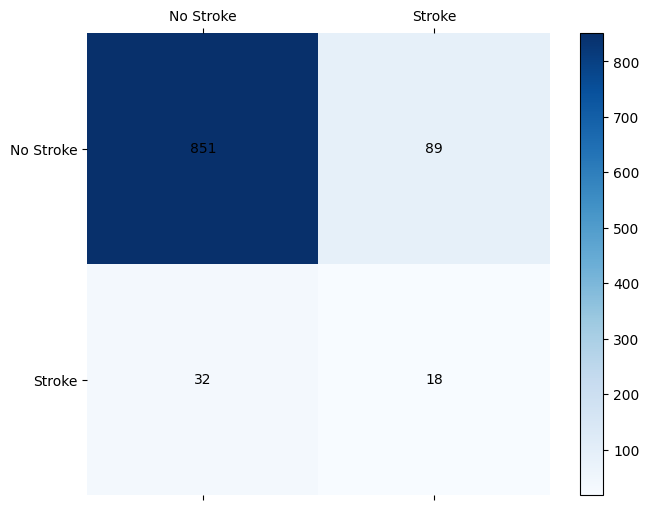

In [95]:
perform_model("Logistic", x_res, y_res, x_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       940
           1       0.21      0.20      0.21        50

    accuracy                           0.92       990
   macro avg       0.59      0.58      0.58       990
weighted avg       0.92      0.92      0.92       990

Balanced Accuracy: 0.5803191489361702
F1 Weighted: 0.9210814309499781
F1 Macro: 0.5826466868508795
[[903  37]
 [ 40  10]]


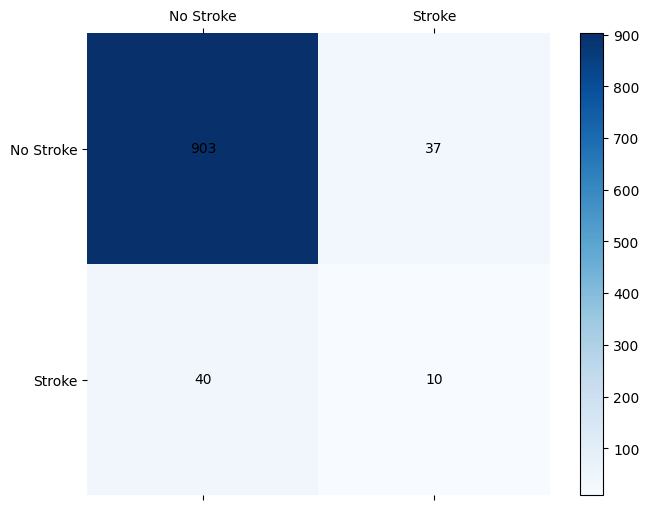

In [96]:
perform_model("RF", x_res, y_res, x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       940
           1       0.13      0.86      0.23        50

    accuracy                           0.71       990
   macro avg       0.56      0.78      0.53       990
weighted avg       0.95      0.71      0.79       990

Balanced Accuracy: 0.7821276595744681
F1 Weighted: 0.79301955983828
F1 Macro: 0.5273386392914519
[[662 278]
 [  7  43]]


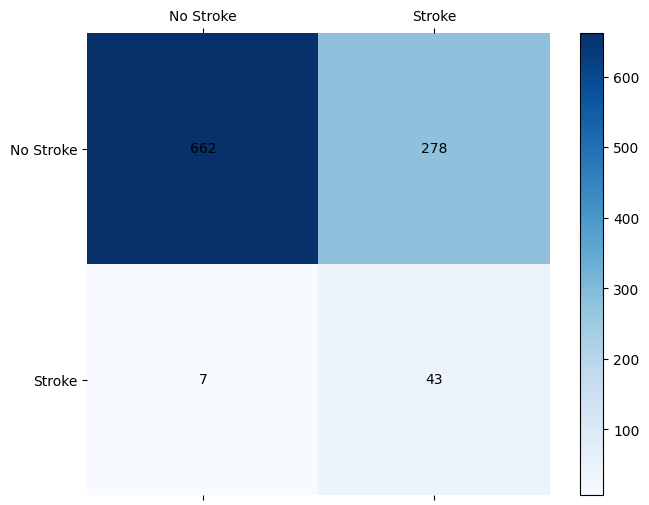

In [97]:
perform_model("SVM", x_res, y_res, x_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       940
           1       0.29      0.14      0.19        50

    accuracy                           0.94       990
   macro avg       0.62      0.56      0.58       990
weighted avg       0.92      0.94      0.93       990

Balanced Accuracy: 0.5609574468085106
F1 Weighted: 0.9291602964215766
F1 Macro: 0.5788548254445421
[[923  17]
 [ 43   7]]


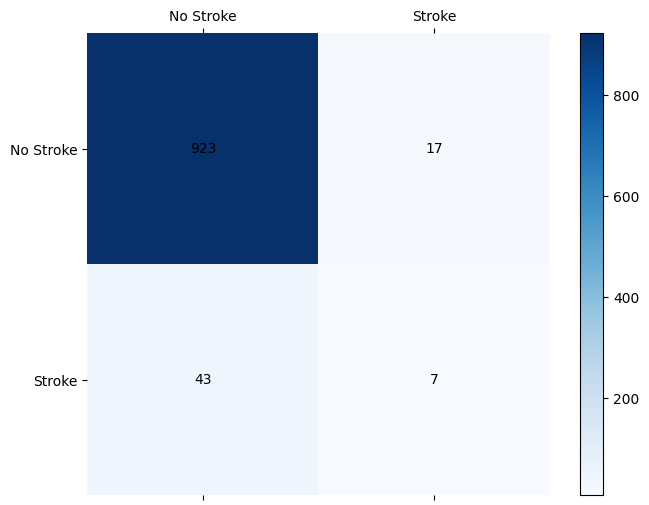

In [98]:
perform_model("XGB", x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       940
           1       0.08      0.02      0.03        50

    accuracy                           0.94       990
   macro avg       0.52      0.50      0.50       990
weighted avg       0.91      0.94      0.92       990

Balanced Accuracy: 0.5041489361702127
F1 Weighted: 0.9214214872326482
F1 Macro: 0.5004877392445087
[[929  11]
 [ 49   1]]


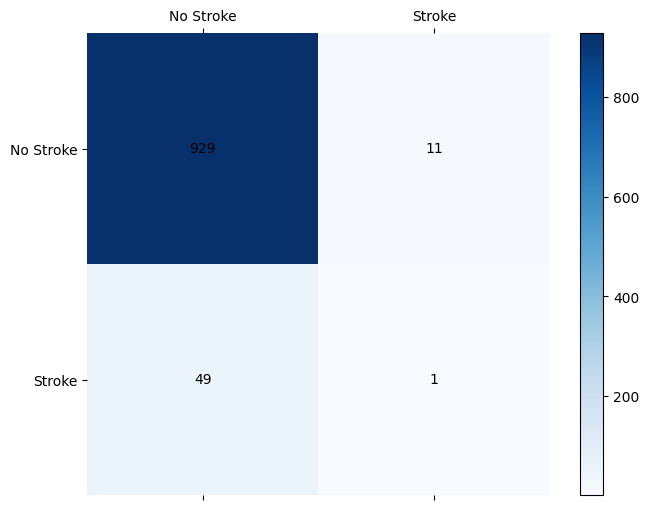

In [99]:
perform_model("KNN", x_train, y_train, x_test, y_test)

Note: The goal of this project is to create a model that will have the highest accuracy of identifying a stroke. In other words, this model prioritizes correctly identifying strokes over minimizing false positives.

Because of this, SVM appears to be the best candidate for this case due to it having the highest recall accuracy among the other 4.

## 5. Hyperparameter Tuning

In [100]:
"""#establish parameters for model to check
svm_param_grid = {
    "C":     [0.1, 0.3, 1, 3, 10, 30, 100],
    "gamma": [0.01, 0.03, 0.1, 0.3, 1, 'scale', 'auto']
}"""

xgb_param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [101]:
"""svm_tune = SVC(kernel = 'rbf', class_weight = 'balanced', random_state = 2)

svm_gs = RandomizedSearchCV(svm_tune, svm_param_grid, cv = 5, scoring = "recall", n_jobs = -1)"""
xgb_tune = XGBClassifier(objective = 'binary:logistic', random_state = 2)

xgb_gs = RandomizedSearchCV(xgb_tune, xgb_param_grid, cv = 5, scoring = "f1_weighted", n_jobs = -1)

In [102]:
#test each parameter value to find the best ones
xgb_gs.fit(x_res, y_res)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [1, 3, 5, 10],
                                        'n_estimators': [50, 100, 200, 250,
                                                         300],
                                        'subsample': [0.7, 0.8, 1.0]},
                   scoring='f1_weighted')

In [103]:
#print best params
print("Best Parameters:", xgb_gs.best_params_)
print("Best F1 Score (Weighted):", xgb_gs.best_score_)

Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best F1 Score (Weighted): 0.9524890056001285


In [104]:
#using those parameters, let's perform our model once more
"""prediction_model = SVC(**svm_gs.best_params_)
prediction_model.fit(x_res, y_res)
x_test.columns = x_test.columns.str.replace(r'[\[\]<>]', '', regex=True)
model_pred = prediction_model.predict(x_test)"""
prediction_model = XGBClassifier(**xgb_gs.best_params_)
prediction_model.fit(x_res, y_res)
x_test.columns = x_test.columns.str.replace(r'[\[\]<>]', '', regex=True)
model_pred = prediction_model.predict(x_test)

<>:2: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\['
C:\Users\cwang\AppData\Local\Temp\ipykernel_11976\1024244762.py:2: SyntaxWarning: invalid escape sequence '\['
  """prediction_model = SVC(**svm_gs.best_params_)


In [105]:
prediction_conf_matrix = confusion_matrix(y_test, model_pred)
prediction_model_report = classification_report(y_test, model_pred, zero_division = 0)
prediction_fl_weighted = f1_score(y_test, model_pred, average = 'weighted')

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       940
           1       0.24      0.30      0.27        50

    accuracy                           0.92       990
   macro avg       0.60      0.62      0.61       990
weighted avg       0.93      0.92      0.92       990

F1-Weighted: 0.9206922929567274


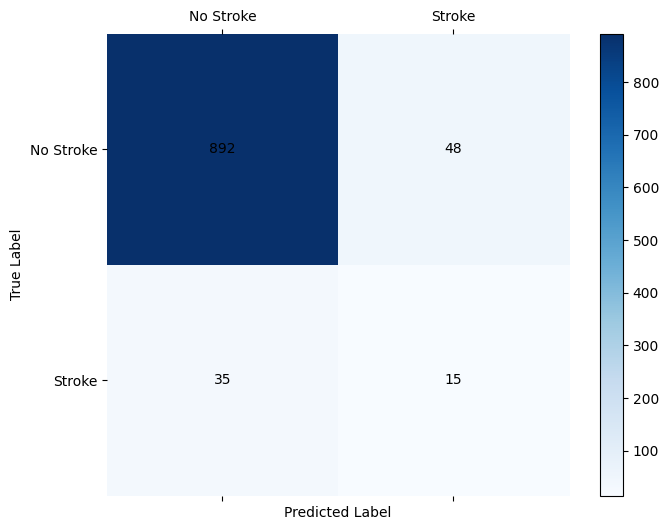

In [106]:
#printing report
print(prediction_model_report)
print(f'F1-Weighted: {prediction_fl_weighted}')

#confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(prediction_conf_matrix, cmap='Blues')
fig.colorbar(cax)

#add labels
class_labels = ["No Stroke", "Stroke"]
ax.set_xticks(np.arange(prediction_conf_matrix.shape[1]))
ax.set_yticks(np.arange(prediction_conf_matrix.shape[0]))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

#add axis labels
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

#remove outline
for spine in ax.spines.values():
    spine.set_visible(False)

# Annotate the matrix with numbers
for i in range(prediction_conf_matrix.shape[0]):
    for j in range(prediction_conf_matrix.shape[1]):
        ax.text(j, i, f'{prediction_conf_matrix[i, j]}', ha = 'center', va = 'center', color = 'black')

plt.show()